# Introduction to Deep Learning with PyTorch

In this notebook, we will go over the basics of Deep Learning using Pytorch. Pytorch is a framework which allows manipulations of tensors using constructs similar to numpy. In addition it has modules to allow auto differentiation to carryout back-propagation which forms the backbone of training a neural network

## What are Neural Networks

Deep learning is based on Artificial Neural networks which are made up of neurons. A neuron takes inputs, calculates the weighted sum and then passes the sum through some kind of non-linear function (called activation function) as shown below:

![Neuron](./images/neuron.png "Neuron")

<br/>
<br/>

We stack these neurons to make a neural network as shown below:
![Neuron](./images/nn.svg "Neuron")

Let us now create a neural network in PyTorch. We will use this network to train a model to take MNIST data as input and produce the class it belongs to.


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

%matplotlib inline

### MNIST 

MNIST dataset has images 28x28 pixels  = 784 pixels. 

We will have 10 units at the output layer to signify the digit (0-9) the image belongs to.

Let us first load the data and print some images

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(0.5, 0.5),
                             ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)

In [3]:
# let us load a batch of training data and checkout its shape
dataiter = iter(trainloader)
images, labels = next(dataiter)

In [4]:
images.size()

torch.Size([128, 1, 28, 28])

image size of `(32,1,28,28)` means that we have 32 images, with each image of size (1x28x28) (channels x height x width)

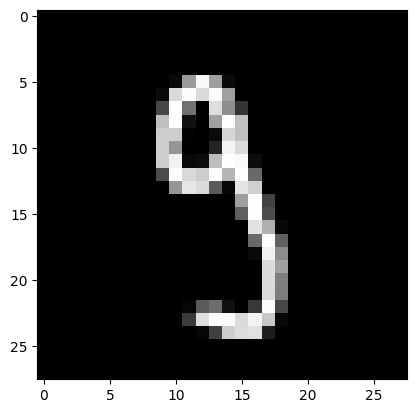

In [5]:
# Let us plot one image
plt.imshow(images[10].numpy().squeeze(), cmap='Greys_r')

### Build Network

In [6]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 192)
        self.fc2 = nn.Linear(192, 128)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return x
    
    def predict(self, x):
        ''' To predict classes by calculating the softmax '''
        logits = self.forward(x)
        return F.softmax(logits, dim=1)

model = NN()
model

NN(
  (fc1): Linear(in_features=784, out_features=192, bias=True)
  (fc2): Linear(in_features=192, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

### Forward pass and Calculate Cross Entropy Loss

In [7]:
# function to view the probability of classification of digit
def view_classification(img, probs):
    probs = probs.data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,7), ncols=2)
    ax1.imshow(img.numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10).astype(int), size='large');
    ax2.set_title('Probability')
    ax2.set_xlim(0, 1.1)
    

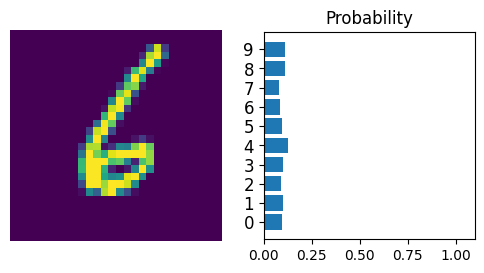

In [8]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
images.resize_(128, 784)

# Forward pass through the network
img_idx = 0
logits = model.forward(images)

# Predict the class from the network output
prediction = F.softmax(logits, dim=1)

img = images[0].data
view_classification(img.reshape(1, 28, 28), prediction[0])

In [9]:
trainloader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

### Back Propagation
We need to now train the network to adjust its weights by first calculating Cross Entropy Loss and then back propagating the error to adjust weights

In [10]:
# Create an optimizer to train the network by carrying out back propagation
model = NN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [11]:
# Train network

epochs = 1
steps = 0
running_loss = 0
eval_freq = 10
for e in range(epochs):
    for images, labels in iter(trainloader):
        steps += 1
        images.resize_(images.size()[0], 784)

        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % eval_freq == 0:
            # Test accuracy
            accuracy = 0
            for ii, (images, labels) in enumerate(testloader):
                
                images = images.resize_(images.size()[0], 784)                
                predicted = model.predict(images).data
                equality = (labels == predicted.max(1)[1])
                accuracy += equality.type_as(torch.FloatTensor()).mean()
            
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/eval_freq),
                  "Test accuracy: {:.4f}".format(accuracy/(ii+1)))
            running_loss = 0

Epoch: 1/1 Loss: 2.0367 Test accuracy: 0.5667
Epoch: 1/1 Loss: 1.3270 Test accuracy: 0.7145
Epoch: 1/1 Loss: 0.8737 Test accuracy: 0.7718
Epoch: 1/1 Loss: 0.7358 Test accuracy: 0.8041
Epoch: 1/1 Loss: 0.6454 Test accuracy: 0.8501
Epoch: 1/1 Loss: 0.5656 Test accuracy: 0.8515
Epoch: 1/1 Loss: 0.5023 Test accuracy: 0.8678
Epoch: 1/1 Loss: 0.4775 Test accuracy: 0.8712
Epoch: 1/1 Loss: 0.4399 Test accuracy: 0.8881
Epoch: 1/1 Loss: 0.3717 Test accuracy: 0.8925
Epoch: 1/1 Loss: 0.3842 Test accuracy: 0.8876
Epoch: 1/1 Loss: 0.3793 Test accuracy: 0.8912
Epoch: 1/1 Loss: 0.3903 Test accuracy: 0.8866
Epoch: 1/1 Loss: 0.3750 Test accuracy: 0.8961
Epoch: 1/1 Loss: 0.3636 Test accuracy: 0.8948
Epoch: 1/1 Loss: 0.3437 Test accuracy: 0.9005
Epoch: 1/1 Loss: 0.3402 Test accuracy: 0.8993
Epoch: 1/1 Loss: 0.3325 Test accuracy: 0.9020
Epoch: 1/1 Loss: 0.3401 Test accuracy: 0.8968
Epoch: 1/1 Loss: 0.3009 Test accuracy: 0.9013
Epoch: 1/1 Loss: 0.3642 Test accuracy: 0.9043
Epoch: 1/1 Loss: 0.3764 Test accur

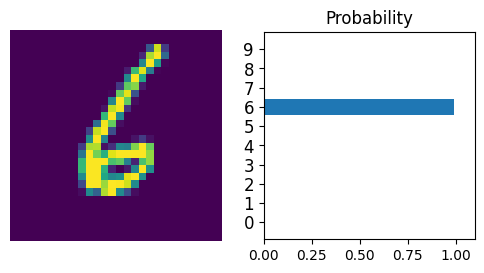

In [12]:

logits = model.forward(img[None,])

# Predict the class from the network output
prediction = F.softmax(logits, dim=1)

view_classification(img.reshape(1, 28, 28), prediction[0])

We can see that model is able to correctly predict the digit after training while before training it predicting all digits with almost equal probability i.e. it was randomly predicting the digit.